In [99]:
#If the version of scikit_learn is not the latest
#!pip install --upgrade scikit-learn imbalanced-learn

In [100]:
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.figure_factory as ff
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,precision_score, recall_score, f1_score, make_scorer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/creditcardfraud/creditcard.csv


***The objective of this project is to determine which transactions are likely to be fraudulent, knowing little information.***

In [101]:
fraud = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Here are some details about the dataset:**

Each row represent one transaction made by a credit card in September 2013 by an European cardholder.

Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.

Feature 'Amount' countains the transaction amount.

Feature 'Class' equals 1 if the transaction was fraudulent and 0 otherwise.

Due to confidentiality issues, the meaning behind the features V1, V2, … V28 is unknown.

## Strategy established :
1. [Understand more about the data](#info)
2. [Preprocessing](#preprocessing)
3. [Rebalancing](#rebalancing)
   - [A - Checking the need](#need)
   - [B - UnderSampling](#undersampling)
   - [C - OverSampling](#oversampling)
4. [Testing models](#models)
   - [A - RandomForestClassifier](#randomforest)
   - [B - XGBClassifier](#xgboost)
   - [C - LGBMClassifier](#light)
5. [Conclusion](#conclusion)

<h2 id="info"> 1 - Gathering more information about the data </h2>

The following lines give crucial informations :

missing values : 0 percentage of fraud : 0.1727485630620034


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud , 1: Fraud)')

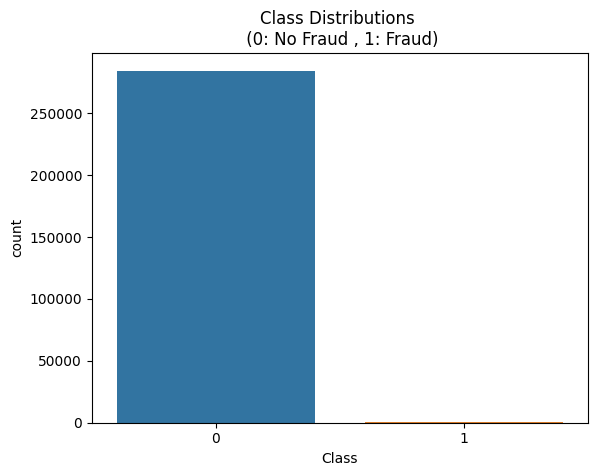

In [102]:
missing_values = fraud.isnull().sum().sum()

fraud_percentage = 100 * sum(fraud['Class']) / fraud.shape[0]

print( 'missing values : ' + str(missing_values) , 'percentage of fraud : ' + str(fraud_percentage))

sns.countplot(x='Class', data=fraud)
plt.title('Class Distributions \n (0: No Fraud , 1: Fraud)')


The data is very unbalanced : the fraud cases do not even represent 0.2% of the number of transactions. We will need to adjust our data tu train our models efficiently.

There's no missing values in this dataset, which makes preprocessing a little bit easier.

To understand if the time has any importance, we can look at the distribution of the fraudulent and not-fraudulent transactions in the time, by displaying the density plot for both of them.

In [103]:
class_0 = fraud.loc[fraud['Class'] == 0]["Time"]
class_1 = fraud.loc[fraud['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

The PCA method that was used guarantees that the V1 - V28 columns are decorrelated, but I will check just to be sure.

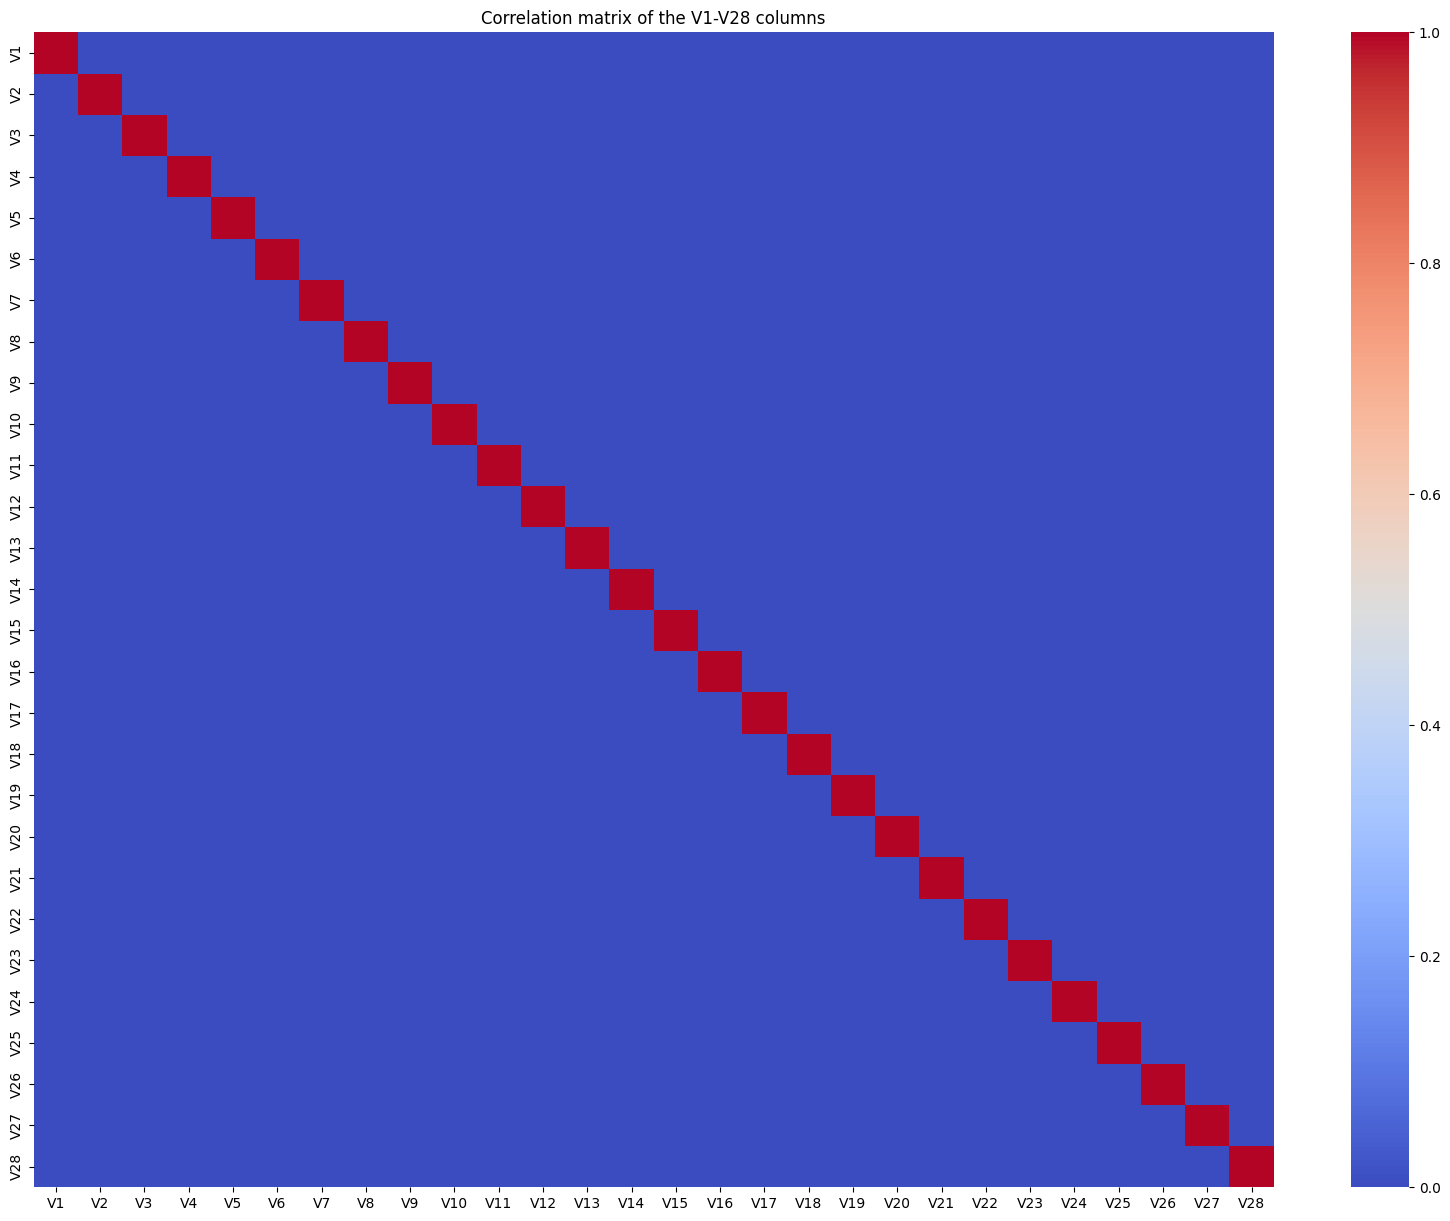

In [104]:

v_features = fraud.loc[:, 'V1':'V28']

correlation_matrix = v_features.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.1f')
plt.title('Correlation matrix of the V1-V28 columns')
plt.show()

The correlation matrix being the identity matrix, we deduce that the covariance of the each columns with another one equals 0, and that all the columns are decorralated.

<h2 id="preprocessing">2 - Preprocessing <h2>

In this section, I basically scale the columns 'Amount' and 'Time' so that the models won't give them more importance than the columns V1 - V28, already scaled within the PCA treatment. I also create the training and validation data.

In [105]:
std_scaler= StandardScaler()
cols_to_scale = ['Amount','Time']

X = fraud.drop('Class', axis = 1)
y = fraud['Class']

X_train,X_valid,y_train, y_valid = train_test_split(X,y,test_size
= 0.20 ,random_state = 42)

std_scaler.fit(X_train[cols_to_scale])

X_train[cols_to_scale]=std_scaler.transform(X_train[cols_to_scale])
X_valid[cols_to_scale]=std_scaler.transform(X_valid[cols_to_scale])


<h2 id="rebalancing">3 - Rebalancing</h2>

<h3 id="need"> A - Checking the usefulness of rebalancing the data</h3>

If the raw data is given to a ML model, it will probably fail to distinguish efficiently the transactions of the class 0 and of the class 1, considering the tiny proportion of fraudulent transactions.

Let's check this by using a simple logistic regression model : 

In [106]:
model= LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_pred_baseline = model.predict(X_valid)

print("--- Reference model (raw data) ---")
print(confusion_matrix(y_valid, y_pred_baseline))
print(classification_report(y_valid, y_pred_baseline))

--- Reference model (raw data) ---
[[56854    10]
 [   41    57]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.58      0.69        98

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962



The model has an accuracy on zeros approaching 1, which means it almost always detects the transactions that aren't fraudulent. This is normal considering the very high proportion of non-fraudulent transactions.

More interesting information comes from the results on ones. Only 58 % of them were found and the model is right about 85% of the time when he labels a transaction as fraudulent. This shows that the training on an unbalanced dataframe might not be the greatest solution.

<h3 id="undersampling"> B - Undersampling </h3>

A method commonly used is undersampling. It consists in reducing the training data in order to have half transactions in class 0 and the other half in class 1.

In [107]:
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

model_under = LogisticRegression(random_state=42)
model_under.fit(X_train_under, y_train_under)

y_pred_under = model_under.predict(X_valid)

print("--- Model with UnderSampling ---")
print(confusion_matrix(y_valid, y_pred_under))
print(classification_report(y_valid, y_pred_under))

--- Model with UnderSampling ---
[[54788  2076]
 [    7    91]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.93      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.95      0.53     56962
weighted avg       1.00      0.96      0.98     56962



This method grants the model the ability to find about 90 percent of the fraudulent transactions, but is clearly underfitting as it was trained on 500 values, and that he labels as fraudulent more than 10000 transactions to find 366 that are really !

<h3 id="oversampling"> C - Oversampling</h3>

A more efficient method is to create fake transactions of class 1 to balance the taining data.

In [108]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model_smote = LogisticRegression(random_state=42)
model_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = model_smote.predict(X_valid)

print("--- Model with SMOTE ---")
print(confusion_matrix(y_valid, y_pred_smote))
print(classification_report(y_valid, y_pred_smote))

--- Model with SMOTE ---
[[55421  1443]
 [    7    91]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.93      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



this model perfoms better than the undersampling one, but it isn't enough considering the very small precision on ones.

**Hypothesis** : the problem doesn't emerge from the oversampling method, but of the model that was used. LogisticRegression is too 'simple' to understand the boundaries between the frauds and non-frauds, because SMOTE created complex boundaries.

<h2 id="models">4 - Testing models </h2>

In this section, I will use three different models : RandomForestClassifier, XGBClassifier and LGBMClassifier in order to verify the hypothesis and find the best model for this situation.

In [109]:
X_train_final = X_train_smote
y_train_final = y_train_smote

<h3 id="randomforest">A - RandomForestClassifier<h3>

In [110]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train_final)
y_pred_rf = rf_model.predict(X_valid)
print("--- RandomForest with SMOTE ---")
print(classification_report(y_valid, y_pred_rf))

--- RandomForest with SMOTE ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.83      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



As expected, the precision got much higher

<h3 id="randomforest">B - XGBClassifier</h3>

In [111]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_final, y_train_final)
y_pred_xgb = xgb_model.predict(X_valid)
print("--- XGBoost with SMOTE ---")
print(classification_report(y_valid, y_pred_xgb))

--- XGBoost with SMOTE ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.75      0.85      0.80        98

    accuracy                           1.00     56962
   macro avg       0.88      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962



This model is less efficient than the RandomForest one (according to the f1 score)

<h3 id="light">C - LGBMClassifier </h3>

In [112]:
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1,verbose=-1)
lgbm_model.fit(X_train_smote, y_train_smote)

y_pred_lgbm = lgbm_model.predict(X_valid)

print("--- LightGBM (LGBM) avec SMOTE ---")
print(confusion_matrix(y_valid, y_pred_lgbm))
print(classification_report(y_valid, y_pred_lgbm))

--- LightGBM (LGBM) avec SMOTE ---
[[56798    66]
 [   16    82]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.55      0.84      0.67        98

    accuracy                           1.00     56962
   macro avg       0.78      0.92      0.83     56962
weighted avg       1.00      1.00      1.00     56962



This model is again less efficient than the RandomForest one, and the xgboost one. It is however much faster. When I first made this notebook, I used only 25 percent of 'test_size' in 'train_test_split' in the previous section, I had a precision near to 80 percent, which might depict an overfitting case.

<h3 id="crossvalidation">D - Cross Validation </h3>

Finally, I will analyze the true efficiency of one model  with cross validation, just to be sure that the results weren't obtained on a fluke. Since the LightGBM model is much faster than the others, it is the one that i will test (the model will train 5 times on the data).

A pipeline is needed because I want to balance the data at the same time as making the cross validation.

In [113]:
#creation of a pipeline
pipe_lgbm = make_pipeline(SMOTE(random_state=42),
                          LGBMClassifier(random_state=42, verbose=-1))

#score definition
scoring = {
    'recall': make_scorer(recall_score, pos_label=1),
    'precision': make_scorer(precision_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

#cross validation
cv_results = cross_validate(pipe_lgbm,X_train,y_train,cv=5,scoring=scoring)

# mean scores
print("\n--- mean cross-validation score (Pipeline SMOTE + LGBM) ---")
print(f"mean F1-Score  :   {cv_results['test_f1'].mean():.4f}")
print(f"mean recall :     {cv_results['test_recall'].mean():.4f}")
print(f"mean precision : {cv_results['test_precision'].mean():.4f}")


--- mean cross-validation score (Pipeline SMOTE + LGBM) ---
mean F1-Score  :   0.6670
mean recall :     0.8401
mean precision : 0.5539


it is exactly the same as with the sample we tried before.

<h2 id="conclusion"> 5 - Conclusion </h2>

All in all, I witnessed the issues encountered in an unbalanced dataset, explored the solutions with UnderSampling and OverSampling, tested and measured the efficiency of different ML models. I can conclude that OverSampling can be a great way to deal with this problem, that RandomForestClassifier is the most precise but is far more slow the LGBMClassifier. To conclude this study, i will find the 10 most important features when it comes to tackling this issue.

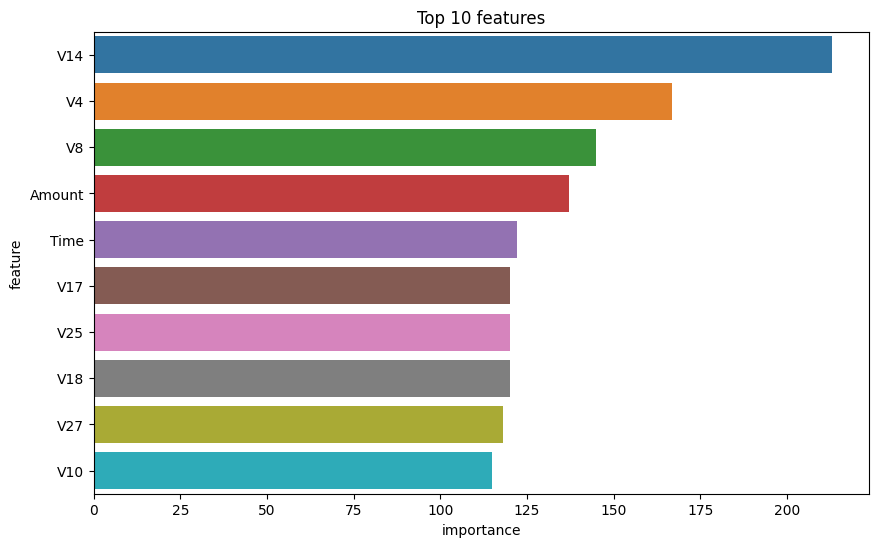

In [114]:
pipe_lgbm.fit(X_train, y_train)
final_lgbm_model = pipe_lgbm.named_steps['lgbmclassifier']

feature_names = X_train.columns

feature_importance = pd.DataFrame(
    {'feature': feature_names, 'importance': final_lgbm_model.feature_importances_}
).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 features')
plt.show()

NB : this top 10 changes when I change the training data, it is not universal.